# 1. Build an image segmentation model using pytorch

In [4]:
# Import the required libraries
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn.functional as F

In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR = "/kaggle/input/project-three"
RESIZE_TO = (256, 256)
BATCH_SIZE = 8
EPOCHS = 20
LR = 1e-4

In [13]:
# Dataset class
class BirdSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.image_dir, self.images[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.masks[idx])).convert("L")

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        mask = (mask > 0).float()  # Binarize mask
        return img, mask


In [14]:
# Transforms and Loaders
transform = T.Compose([
    T.Resize(RESIZE_TO),
    T.ToTensor()
])

train_loader = DataLoader(BirdSegmentationDataset(
    f"{BASE_DIR}/new_dataset/train/images",
    f"{BASE_DIR}/new_dataset/train/masks",
    transform
), batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(BirdSegmentationDataset(
    f"{BASE_DIR}/new_dataset/valid/images",
    f"{BASE_DIR}/new_dataset/valid/masks",
    transform
), batch_size=BATCH_SIZE, shuffle=False)

In [15]:
#  UNET MODEL
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.dec4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)


# 2. Train your model using [Bird sound datasets](https://yuad-my.sharepoint.com/personal/youshan_zhang_yu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fyoushan%5Fzhang%5Fyu%5Fedu%2FDocuments%2FBird%5FSound%5FDataset&ga=1)

In [16]:
# Training
model = UNet().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        preds = model(images)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch}/{EPOCHS}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 0.3533
Epoch [2/20], Loss: 0.1730
Epoch [3/20], Loss: 0.1252
Epoch [4/20], Loss: 0.1033
Epoch [5/20], Loss: 0.0968
Epoch [6/20], Loss: 0.0945
Epoch [7/20], Loss: 0.0884
Epoch [8/20], Loss: 0.0877
Epoch [9/20], Loss: 0.0847
Epoch [10/20], Loss: 0.0832
Epoch [11/20], Loss: 0.0804
Epoch [12/20], Loss: 0.0777
Epoch [13/20], Loss: 0.0770
Epoch [14/20], Loss: 0.0745
Epoch [15/20], Loss: 0.0766
Epoch [16/20], Loss: 0.0743
Epoch [17/20], Loss: 0.0741
Epoch [18/20], Loss: 0.0703
Epoch [19/20], Loss: 0.0691
Epoch [20/20], Loss: 0.0680


# 3.Evaluate your model using the test images

In [17]:
# Test Dataset Loader
test_dataset = BirdSegmentationDataset(
    f"{BASE_DIR}/new_dataset/test/images",
    f"{BASE_DIR}/new_dataset/test/masks",
    transform
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [18]:
def compute_iou(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).float()
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum() - intersection
    if union == 0:
        return torch.tensor(1.0) if intersection == 0 else torch.tensor(0.0)
    return intersection / union


In [19]:
def compute_iou(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).float()
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum() - intersection
    if union == 0:
        return torch.tensor(1.0) if intersection == 0 else torch.tensor(0.0)
    return intersection / union

model.eval()
ious = []

print("Per-image IoU scores:")

with torch.no_grad():
    for i, (img, true_mask) in enumerate(test_loader):
        img = img.to(DEVICE)
        true_mask = true_mask.to(DEVICE)

        pred = model(img)
        pred = torch.sigmoid(pred)

        iou = compute_iou(pred, true_mask)
        ious.append(iou.item())

        # Print individual scores as float and %
        print(f"Image {i+1:02d}: IoU = {iou.item():.4f} ({iou.item() * 100:.2f}%)")

mean_iou = sum(ious) / len(ious)
print("\n Final Evaluation Result:")
print(f"Mean IoU = {mean_iou:.4f} ({mean_iou * 100:.2f}%)")



Per-image IoU scores:
Image 01: IoU = 0.2869 (28.69%)
Image 02: IoU = 0.2282 (22.82%)
Image 03: IoU = 0.1950 (19.50%)
Image 04: IoU = 0.4523 (45.23%)
Image 05: IoU = 0.5118 (51.18%)
Image 06: IoU = 0.7025 (70.25%)
Image 07: IoU = 0.8891 (88.91%)
Image 08: IoU = 0.5799 (57.99%)
Image 09: IoU = 0.3924 (39.24%)
Image 10: IoU = 0.7334 (73.34%)
Image 11: IoU = 0.3392 (33.92%)
Image 12: IoU = 0.3554 (35.54%)
Image 13: IoU = 0.0636 (6.36%)
Image 14: IoU = 0.6249 (62.49%)
Image 15: IoU = 0.6720 (67.20%)
Image 16: IoU = 0.6988 (69.88%)
Image 17: IoU = 0.8609 (86.09%)
Image 18: IoU = 0.8397 (83.97%)
Image 19: IoU = 0.8062 (80.62%)
Image 20: IoU = 0.7791 (77.91%)
Image 21: IoU = 0.7322 (73.22%)
Image 22: IoU = 0.6755 (67.55%)
Image 23: IoU = 0.7924 (79.24%)
Image 24: IoU = 0.6768 (67.68%)
Image 25: IoU = 0.7202 (72.02%)
Image 26: IoU = 0.8387 (83.87%)
Image 27: IoU = 0.8052 (80.52%)
Image 28: IoU = 0.5964 (59.64%)
Image 29: IoU = 0.7707 (77.07%)
Image 30: IoU = 0.8197 (81.97%)
Image 31: IoU = 0.8

In [20]:
mean_iou = sum(ious) / len(ious)
print("\n Final Evaluation Result:")
print(f"Mean IoU = {mean_iou:.4f} ({mean_iou * 100:.2f}%)")


 Final Evaluation Result:
Mean IoU = 0.6505 (65.05%)


In [21]:
# Save the trained model's weights
torch.save(model.state_dict(), "/kaggle/working/unet_segmentation_model.pt")
print(" Model saved as unet_segmentation_model.pt")


 Model saved as unet_segmentation_model.pt


# 4. Your IoU score should be higher than 60

As we see the above results, we can observe that the IoU score is 65.05%

In [27]:
import matplotlib.pyplot as plt

def show_segmentation_comparison(model, dataset, index):
    model.eval()
    img, true_mask = dataset[index]
    with torch.no_grad():
        pred_mask = model(img.unsqueeze(0).to(DEVICE))
        pred_mask = torch.sigmoid(pred_mask).cpu().squeeze().numpy()

    img_np = img.permute(1, 2, 0).numpy()
    true_mask_np = true_mask.squeeze().numpy()
    pred_binary = (pred_mask > 0.5).astype(float)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask_np, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_binary, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


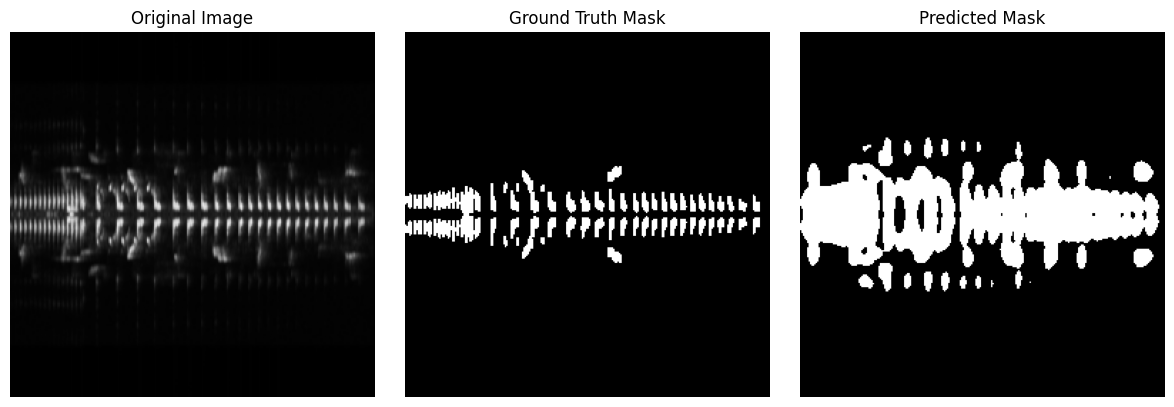

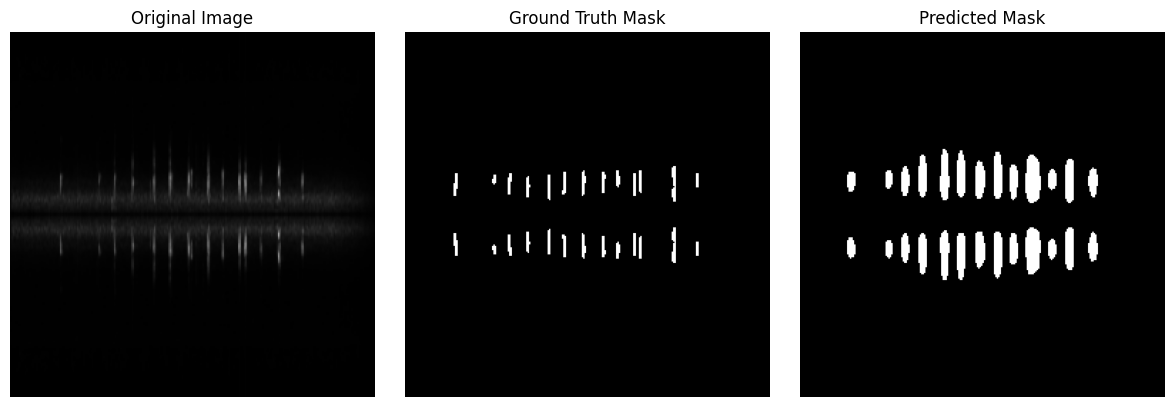

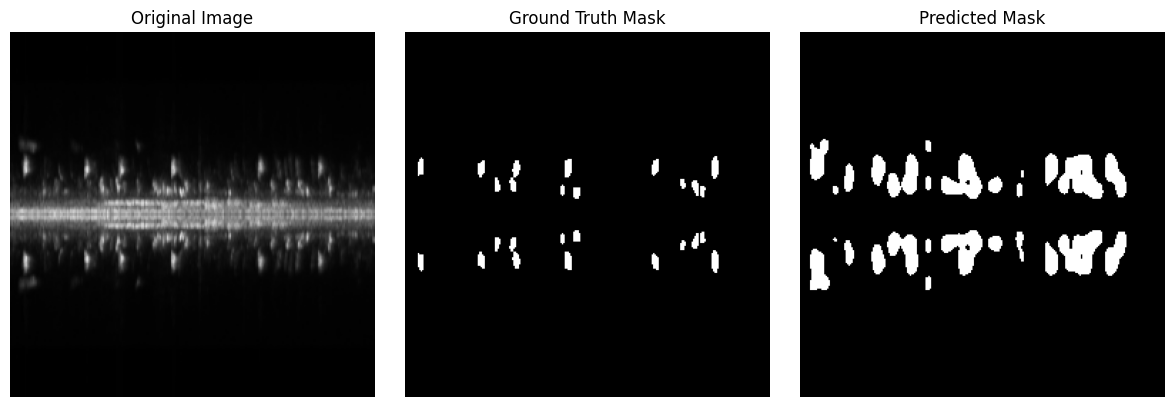

In [29]:
show_segmentation_comparison(model, test_dataset, index=0)
show_segmentation_comparison(model, test_dataset, index=1)
show_segmentation_comparison(model, test_dataset, index=2)


In [23]:
def compute_metrics(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).float()
    true_mask = true_mask.float()

    pred_flat = pred_mask.view(-1)
    true_flat = true_mask.view(-1)

    intersection = (pred_flat * true_flat).sum()
    union = pred_flat.sum() + true_flat.sum() - intersection

    
    iou = (intersection / union) if union > 0 else torch.tensor(1.0)
    dice = (2 * intersection / (pred_flat.sum() + true_flat.sum())) if (pred_flat.sum() + true_flat.sum()) > 0 else torch.tensor(1.0)
    f1 = dice  

    return iou.item() * 100, dice.item() * 100, f1.item() * 100


In [26]:
model.eval()

ious, dices, f1s = [], [], []


with torch.no_grad():
    for idx, (img, mask) in enumerate(test_loader):
        img, mask = img.to(DEVICE), mask.to(DEVICE)
        pred = model(img)
        pred = torch.sigmoid(pred)

        iou, dice, f1 = compute_metrics(pred, mask)

        ious.append(iou)
        dices.append(dice)
        f1s.append(f1)

        print(f"Image {idx+1:02d} - IoU: {iou:.2f}%, Dice: {dice:.2f}%, F1: {f1:.2f}%")

# Final Averages
avg_iou = sum(ious) / len(ious)
avg_dice = sum(dices) / len(dices)
avg_f1 = sum(f1s) / len(f1s)

print("\n Average Scores Across Test Set:")
print(f"Mean IoU : {avg_iou:.2f}%")
print(f"Mean Dice: {avg_dice:.2f}%")
print(f"Mean F1  : {avg_f1:.2f}%")

 

Image 01 - IoU: 28.69%, Dice: 44.58%, F1: 44.58%
Image 02 - IoU: 22.82%, Dice: 37.16%, F1: 37.16%
Image 03 - IoU: 19.50%, Dice: 32.63%, F1: 32.63%
Image 04 - IoU: 45.23%, Dice: 62.29%, F1: 62.29%
Image 05 - IoU: 51.18%, Dice: 67.71%, F1: 67.71%
Image 06 - IoU: 70.25%, Dice: 82.53%, F1: 82.53%
Image 07 - IoU: 88.91%, Dice: 94.13%, F1: 94.13%
Image 08 - IoU: 57.99%, Dice: 73.41%, F1: 73.41%
Image 09 - IoU: 39.24%, Dice: 56.36%, F1: 56.36%
Image 10 - IoU: 73.34%, Dice: 84.62%, F1: 84.62%
Image 11 - IoU: 33.92%, Dice: 50.65%, F1: 50.65%
Image 12 - IoU: 35.54%, Dice: 52.44%, F1: 52.44%
Image 13 - IoU: 6.36%, Dice: 11.95%, F1: 11.95%
Image 14 - IoU: 62.49%, Dice: 76.91%, F1: 76.91%
Image 15 - IoU: 67.20%, Dice: 80.38%, F1: 80.38%
Image 16 - IoU: 69.88%, Dice: 82.27%, F1: 82.27%
Image 17 - IoU: 86.09%, Dice: 92.53%, F1: 92.53%
Image 18 - IoU: 83.97%, Dice: 91.29%, F1: 91.29%
Image 19 - IoU: 80.62%, Dice: 89.27%, F1: 89.27%
Image 20 - IoU: 77.91%, Dice: 87.58%, F1: 87.58%
Image 21 - IoU: 73.22

In [28]:
# Final Averages
avg_iou = sum(ious) / len(ious)
avg_dice = sum(dices) / len(dices)
avg_f1 = sum(f1s) / len(f1s)

print("\n Average Scores Across Test Set:")
print(f"Mean IoU : {avg_iou:.2f}%")
print(f"Mean Dice: {avg_dice:.2f}%")
print(f"Mean F1  : {avg_f1:.2f}%")

 


 Average Scores Across Test Set:
Mean IoU : 65.05%
Mean Dice: 76.69%
Mean F1  : 76.69%


# 5. Write a 3-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


https://www.researchgate.net/publication/391328362_Bird_Sound_Image_Segmentation_Using_UNet